In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from libraries.methods import Mandelbrot

### Analysis of convergence

Range Analysis
 - Compare two sample ranges to demonstrate how variance depends on the rate at which our samples are accepted

 Convergence due to accuracy (iteration)
 - For each sampling method simulate the same samples at different accuracy limits. Run multiple simulations and take the average for each parameter change to create a confidence interval

 Convergence due to increasing samples
  - For each sampling method generate sample sets with an increasing number of samples. Run multiple simulations and take the average for each parameter change to create a confidence interval


  The mandlebrot class writes simulations to csv. Therefore each csv file contains simulations for 1 set of parameters.
  Files have been manually copied into the following directories for preservation and analysis (so files are not overwritten).

In [6]:
#### Samples statistics

# Sample mean
def expected_value(x):
    mean = np.sum(x)/len(x)
    return mean
# Sample variance (unbiased calculation)
def sample_var(x):
    mean = np.sum(x)/len(x)
    sample_var = np.sum((x- mean)**2)/(len(x)-1)
    return sample_var

In [7]:
# Files are large so everything has been written to csv
# Read files in and calculate mean and variance across all simulations for each parameter change

def read_simulations(m,files,location):
    # initilize arrays for parameters and sample statistics
    mean = []
    sd = []
    n_ar = []
    i_ar = []
    
    for file in files:
        # extract parameters from file name
        config = file.replace('Mandlebrot Area Simulations for {} '.format(m),"").replace(".csv","")
        config = config.split(" ")
        n = config[0].replace('n','')
        # s = config[1].replace('s','')
        i = config[2].replace('i','')
        n_ar.append(int(float(n)))
        i_ar.append(int(float(i)))

        # read simulation results and calculate sample statistics
        sample = pd.read_csv(os.path.join("data",location,file))['Area']
        sample = np.array(sample)
        sample_mean =  expected_value(sample)
        sample_v =  sample_var(sample)
        mean.append(sample_mean)
        sd.append(np.sqrt(sample_v))

    # order results by parameter
    result= sorted(zip(n_ar,i_ar,mean,sd))
    n_ar = [i[0] for i in result]
    i_ar = [i[1] for i in result]
    mean = [i[2] for i in result]
    sd = [i[3] for i in result]

    return n_ar,i_ar,mean,sd

In [8]:
#color dictionary for plotting
colour_dict = {"random":'tab:blue',"hypercube":'tab:orange','orthogonal':'tab:green'}

In [3]:
## Best estimate of Am
# uses i10000, n40000, s50
area_estimate = 1.50650448
area_estimate_std = np.sqrt(3.8032102139e-06)

#### Range Analysis

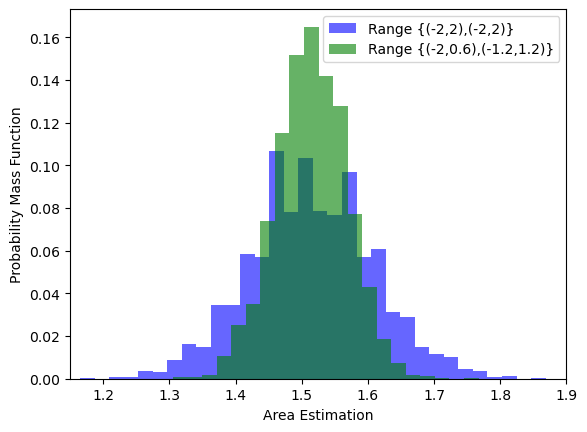

Region capturing radius 2:  Mean 1.5153433600000001 Sample Var 0.008761105493009002
Reduced Area:  Mean 1.5145014144 Sample Var 0.002882753539657804


In [10]:
# Read simulation results for sample ranges
already_run = True
random = pd.read_csv("data/sample range/Mandlebrot Area Simulations for random n2500 s5000 i500.csv")['Area']
random_max_range = pd.read_csv("data/sample range/Mandlebrot Area Simulations for random n2500 s5000 i500 a.csv")['Area']
# hypercube = pd.read_csv("data/sample range/Mandlebrot Area Simulations for hypercube n2500 s5000 i500.csv")['Area']
# hypercube_max_range = pd.read_csv("data/sample range/Mandlebrot Area Simulations for hypercube n2500 s5000 i500 a.csv")['Area']
# orthogonal = pd.read_csv("data/sample range/Mandlebrot Area Simulations for orthogonal n2500 s5000 i500.csv")['Area']
# orthogonal_max_range = pd.read_csv("data/sample range/Mandlebrot Area Simulations for orthogonal n2500 s5000 i500 a.csv")['Area']

# calculate weights for probability function
random = np.array(random)
random_max_range = np.array(random_max_range)
weights = np.ones_like(random) / len(random)
weights_s = np.ones_like(random_max_range) / len(random_max_range)
binwidth = 0.022

plt.hist(random_max_range,weights=weights_s,bins=np.arange(min(random_max_range), max(random_max_range) + binwidth, binwidth),alpha = 0.6,label= "Range {(-2,2),(-2,2)}",color="blue")
plt.hist(random,weights=weights,bins=np.arange(min(random), max(random) + binwidth, binwidth),alpha = 0.6,label= "Range {(-2,0.6),(-1.2,1.2)}",color = 'green')
plt.legend(loc='best')
plt.xlabel("Area Estimation")
plt.ylabel("Probability Mass Function")
plt.xlim(1.15,1.9)
plt.savefig(os.path.join('images',"area reduction random.png"))
plt.show()

print("Region capturing radius 2: ","Mean", expected_value(random_max_range),"Sample Var",sample_var(random_max_range))
print("Reduced Area: ","Mean", expected_value(random),"Sample Var", sample_var(random))

#### Convergence due to increasing accuracy

In [11]:
# parameters for iteration convergence
x_min, x_max = (-2, 0.6)
y_min, y_max = (-1.2, 1.2)

iterations = 5000 # max iterations
samples = 50**2
simulations = 50

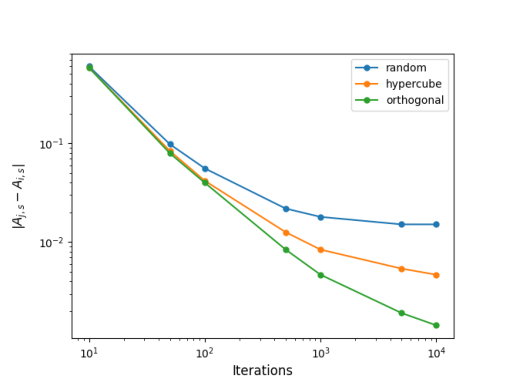

In [5]:
if already_run:
    img = plt.imread('images/iterations_convergence_error.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    # initilize nested list for iteration convergence plot
    convergence = [[],[],[]]
    ci = [[],[],[]] # confidence intervals

    # The convergence is computed for each sampling method
    methods_list = ['random', 'hypercube', 'orthogonal']
    for method in methods_list: 
        print(f'CURRENTLY USING {method} SAMPLING METHOD.')

        # Simulate multiple times max iteration value i and save samples drawn (randomly generated lattice)
        Mandelbrot_Functions = Mandelbrot(method, samples, iterations, x_min, x_max, y_min, y_max)
        samples_matrix = Mandelbrot_Functions.simulate(simulations,True,True)[2]

        # initilize sample statistic results for iteration convergence plot
        area_values = []
        error_bars = []

        # loop through values j < i
        x = list(range(100,iterations,250))
        for j in x:
            Mandelbrot_Functions.max_iters = j
            # initilize results array for simulations of the same parameter
            area_sample_vector = []
            
            # repeat simulation for each lattice
            for k in range(0, len(samples_matrix)):
                area_sample_vector.append(Mandelbrot_Functions.estimate_area(samples_matrix[j]))

            # write area estimations to csv
            areas_df = pd.DataFrame(area_sample_vector, columns=["Area"])
            areas_df.to_csv(os.path.join("data","Mandlebrot Area Simulations for {} n{} s{} i{}.csv".format(method,samples,k+1,j)), 
            index=False)
            
            # plot convergence for large accuracy
            area_sample = np.mean(area_sample_vector) # We obtain A_{i,s}.
            area_values.append(area_sample)
            # Each computed area A_{i,s} is compared to the one obtained with the most iterations (A_{M})
            convergence[methods_list.index(method)].append(abs(area_sample - area_estimate))

            area_sample_std = Mandelbrot_Functions.sample_standard_deviation(area_sample_vector)
            error_bars.append(area_sample_std)
        
        plt.plot(x,convergence[methods_list.index(method)], marker='.',markersize=10, label=method)

        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Iterations', fontsize=12)
        plt.ylabel(r'$A_{j,s}$', fontsize=12)
        plt.savefig(os.path.join('images',"iterations convergence error.png"))
        plt.show()

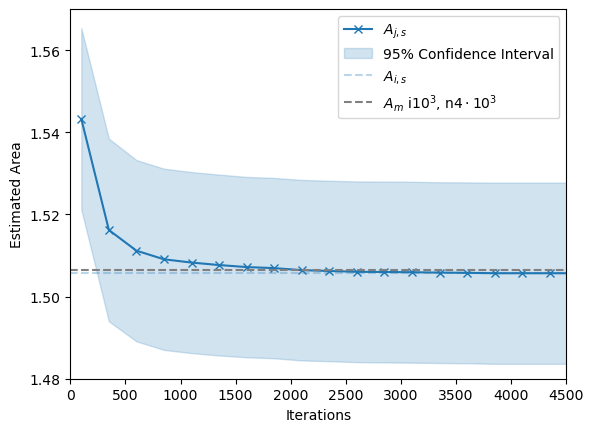

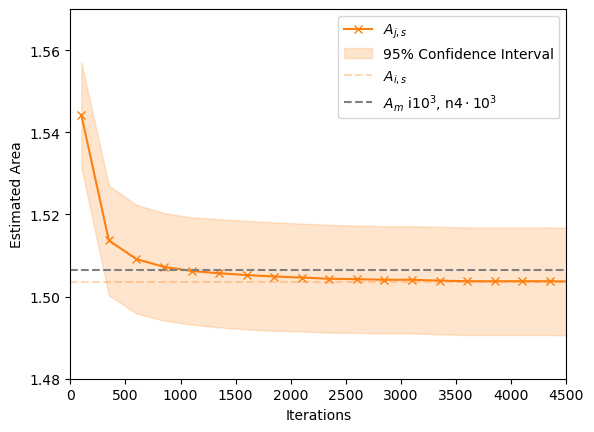

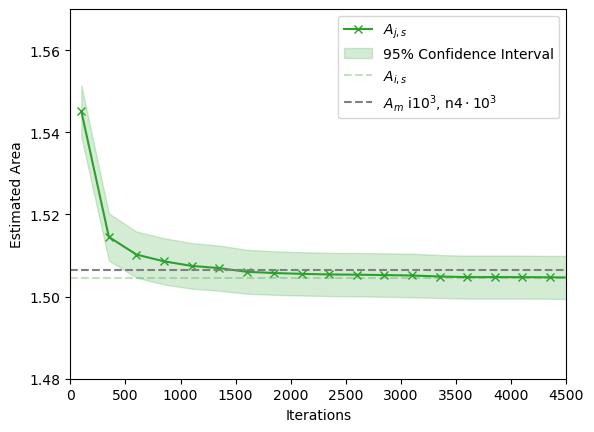

In [17]:
# identify files for iteration convergence
files = os.listdir("data/iterations")
random = [i for i in files if 'random' in i]
hypercube = [i for i in files if 'hypercube' in i]
orthogonal = [i for i in files if 'orthogonal' in i]

method = ['random','hypercube','orthogonal']
for m in method:
    if m == 'random':
        files = random
    elif m == 'hypercube':
        files = hypercube
    else: 
        files = orthogonal

    # read files and compute sample average and variance for each parameter value
    n_ar,i_ar,mean,sd = read_simulations(m,files,'iterations')
    ci_min = mean-sd*(np.ones(len(sd))*1.96/np.sqrt(len(sd)))
    ci_max = mean+sd*(np.ones(len(sd))*1.96/np.sqrt(len(sd)))

    plt.plot(i_ar, mean, 'x-', label = "$A_{j,s}$",color = colour_dict[m]) #yerr=sd, capsize=5, marker='.',markersize=10,
    plt.fill_between(i_ar,ci_min,ci_max,alpha=0.2,label = "95% Confidence Interval",color = colour_dict[m])
    plt.hlines(mean[-1],xmin=0,xmax=5000,alpha=0.3,linestyles='dashed',label = "$A_{i,s}$",color = colour_dict[m])
    plt.hlines(area_estimate,xmin=0,xmax=5000,colors='grey',linestyles='dashed',label='$A_{m}$ i$10^3$, n$4 \cdot 10^3$')
    
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Estimated Area")
    plt.xlim(0,4500)
    plt.ylim(1.48,1.57)
    plt.savefig(os.path.join('images',"{} iterations convergence.png".format(m)))
    plt.show()

#### Convergence from increasing sample size

In [24]:
# parameters for sample convergence
x_min, x_max = (-2, 0.6)
y_min, y_max = (-1.2, 1.2)

iterations = 1000
# samples = 150**2 # max samples drawn
simulations = 50

In [ ]:
# simulate sampling methods with an increasing number of samples
method = ['random','hypercube','orthogonal']
for m in method:
    for s in np.linspace(10,150,21):
        samples = int(s**2)
        Mandelbrot_Functions = Mandelbrot(m, samples, iterations, x_min, x_max, y_min, y_max)
        mean_area, areas_found = Mandelbrot_Functions.simulate(simulations)

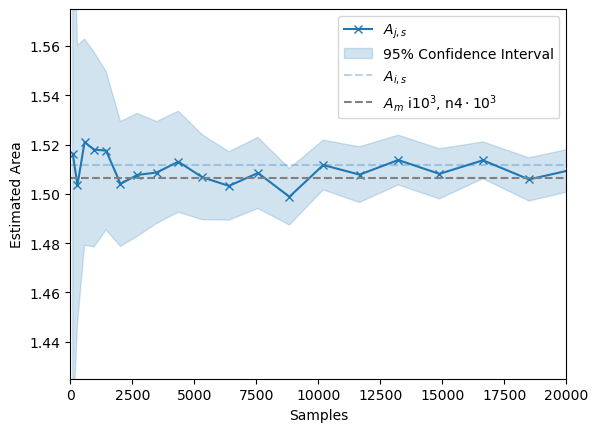

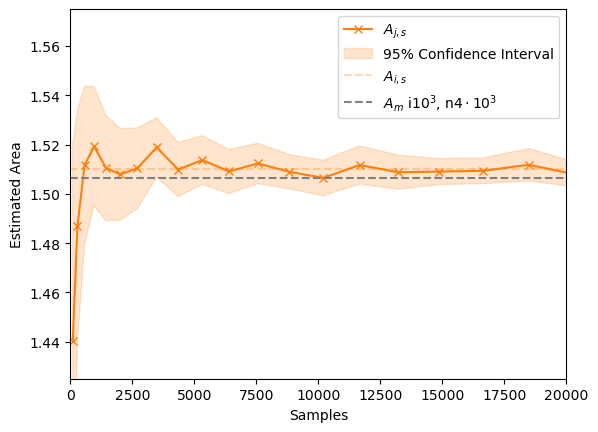

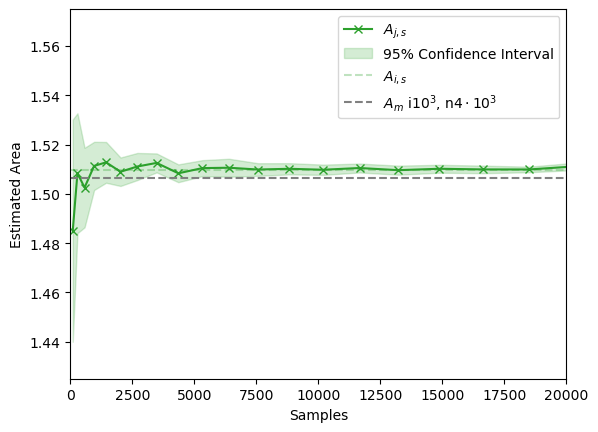

In [28]:
# identify files for sample convergence
files = os.listdir("data/samples")
random = [i for i in files if 'random' in i]
hypercube = [i for i in files if 'hypercube' in i]
orthogonal = [i for i in files if 'orthogonal' in i]

method = ['random','hypercube','orthogonal']
for m in method:

    if m == 'random':
        files = random
    elif m == 'hypercube':
        files = hypercube
    else: 
        files = orthogonal

    # read files and compute sample average and variance for each parameter value
    n_ar,i_ar,mean,sd = read_simulations(m,files,'samples')
    ci_min = mean-sd*(np.ones(len(sd))*1.96/np.sqrt(len(sd)))
    ci_max = mean+sd*(np.ones(len(sd))*1.96/np.sqrt(len(sd)))

    plt.plot(n_ar, mean, 'x-', label="$A_{j,s}$",color = colour_dict[m]) #yerr=sd, capsize=5, marker='.',markersize=10,
    plt.fill_between(n_ar,ci_min,ci_max,alpha=0.2,label = "95% Confidence Interval",color = colour_dict[m])
    plt.hlines(mean[-1],xmin=0,xmax=20000,alpha=0.3,linestyles='dashed',label = "$A_{i,s}$",color = colour_dict[m]) 
    plt.axhline(y = area_estimate, color = 'grey', linestyle = 'dashed', label = "$A_{m}$ i$10^3$, n$4 \cdot 10^3$")

    plt.legend(loc='best')
    plt.xlabel("Samples")
    plt.ylabel("Estimated Area")
    plt.xlim(0,20000)
    plt.ylim(1.425,1.575)
    plt.savefig(os.path.join('images',"Samples {} convergence confidence interval i1000 s50.png".format(m)))
    plt.show()